# Importing the datasets



In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import numpy as np
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
# importing links database

# downloaded = drive.CreateFile({'id':'1hPicFMLvH7XRMNICr9oz8DYKjgFsKAUq'}) # replace the id with id of file you want to access
# downloaded.GetContentFile('links.csv')
# links = pd.read_csv('links.csv', sep=',')

In [ ]:
# links.head()

In [ ]:
# importing movies database

downloaded = drive.CreateFile({'id':'1_N6stt1n7HMzbbWtdBE8DlP_5UAie33C'}) # replace the id with id of file you want to access
downloaded.GetContentFile('movies.csv')
movies = pd.read_csv('movies.csv', sep=',')

In [ ]:
movies.loc[movies['title'].str.contains('Pulp')] # experimenting 

,movieId,title,genres
257,296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller


In [ ]:
#movies['year'] = movies['title'].apply(lambda x: x[-5:-1]) #getting the movies' year of release
#movies['title'] = movies['title'].apply(lambda x: x[:-7]) # taking out the year of the movie title

In [ ]:

#df['Year'] = df['title'].str.extract(r"\(([A-Za-z]+)\)", expand=False)

#everything inside parenthesis (year) goes to a new column 'year'
# movies['year'] = movies['title'].str.extract(r"\((.*?)\)", expand=False) 

# take out the year in parenthesis off of the title
# movies['title'] = movies['title'].str.replace(r"\(.*\)","") 



In [ ]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
#from google.colab import drive
#drive.mount('drive')

In [ ]:
#movies.to_csv('movies.csv')
#!cp data.csv "drive/My Drive/"

In [ ]:
# importing ratings database
downloaded = drive.CreateFile({'id':'1YjVOY4TIf3tvhIGo8LswRV-fN0OROzU1'}) # replace the id with id of file you want to access
downloaded.GetContentFile('ratings.csv')
ratings = pd.read_csv('ratings.csv', sep=',')

In [ ]:
ratings.tail()

,userId,movieId,rating,timestamp
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352
100835,610,170875,3.0,1493846415


In [ ]:
# importing tags database
# downloaded = drive.CreateFile({'id':'1XlV-1z1HXgVrFVy901c23L0kqnl1aj5a'}) # replace the id with id of file you want to access
# downloaded.GetContentFile('tags.csv')
# tags = pd.read_csv('tags.csv', sep=',')

In [ ]:
# pd.to_datetime(tags['timestamp']).dt.date #something's wrong. The same date for all? Don't think so...

In [ ]:
#from datetime import datetime
# tags['datetime']=[datetime.fromtimestamp(x) for x in tags['timestamp']] # now we're talking.

# Joining **movie** df and **ratings** df together

##### **movie** df: Merging **movies** df with **ratings** df, keeping userId

In [ ]:
movie = pd.merge(ratings, movies, on='movieId') #keeping ratings by user

In [ ]:
# movie['title'] = movie['title'].astype("str") #converting the title from type object to string

In [ ]:
# adding a column "datetime" so we have a notion of the ratings' dates. Not really relevant for the model, just curiosity

# from datetime import datetime
# movie['datetime']=[datetime.fromtimestamp(x) for x in movie['timestamp']]

##### **movie2** df: Find the mean rating and merge it with the **movies** df, not considering the userId

In [ ]:
rated = ratings.groupby(['movieId']).mean() #mean rating

movie2 = movies.merge(rated, how='left',left_on=movies['movieId'], right_on=[rated.index])

movie2 = movie2.drop(['key_0','userId'],1) # dropping irrelevant columns

In [ ]:
movie2['rating'] = round(movie2['rating'],2) #rounding the ratings to two decimal places

In [ ]:
movie2.head()

,movieId,title,genres,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.92,1.129835e+09
1,2,Jumanji (1995),Adventure|Children|Fantasy,3.43,1.135805e+09
2,3,Grumpier Old Men (1995),Comedy|Romance,3.26,1.005110e+09
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,2.36,8.985789e+08
4,5,Father of the Bride Part II (1995),Comedy,3.07,9.926643e+08


# ratings_mean_count: A df with titles and mean ratings, and also a column with rating counts


In [ ]:
movie.groupby('title')['rating'].count().sort_values(ascending=False).head() #number of ratings for each movie

title
Forrest Gump (1994)                 329
Shawshank Redemption, The (1994)    317
Pulp Fiction (1994)                 307
Silence of the Lambs, The (1991)    279
Matrix, The (1999)                  278
Name: rating, dtype: int64

Good movies normally receive higher ratings. Now we know that both the average rating per movie and the number of ratings per movie are important attributes

In [ ]:
# creating a new dataframe that contains both attributes

ratings_mean_count = pd.DataFrame(movie.groupby('title')['rating'].mean()) # mean ratings

In [ ]:
ratings_mean_count['rating_counts'] = pd.DataFrame(movie.groupby('title')['rating'].count()) #total ratings for each movie

In [ ]:
ratings_mean_count.sort_values(by="rating_counts", ascending=False).head() # top 5 most rated/popular movies

,rating,rating_counts
title,,
Forrest Gump (1994),4.164134,329
"Shawshank Redemption, The (1994)",4.429022,317
Pulp Fiction (1994),4.197068,307
"Silence of the Lambs, The (1991)",4.161290,279
"Matrix, The (1999)",4.192446,278


# Plotting to better understand our data

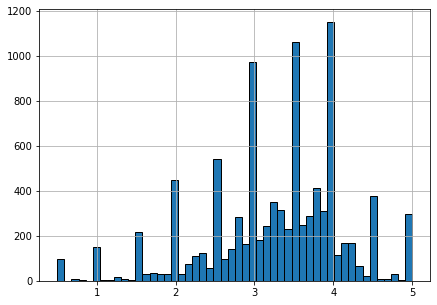

In [ ]:
# plotting a histogram for average ratings

import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))

plt.rcParams['patch.force_edgecolor'] = True

ratings_mean_count['rating'].hist(bins=50)
plt.show()

The integer values have taller bars than the floating values, since most of the users rate an integer value, like 1, 2, 3, 4 or 5.

<Figure size 504x360 with 0 Axes>

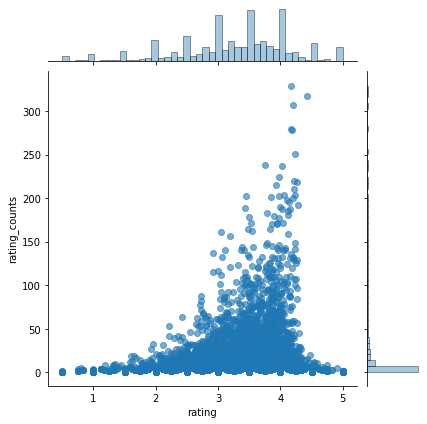

In [ ]:
# plotting average ratings against the number of ratings

import seaborn as sns 

plt.figure(figsize=(7,5))

plt.rcParams['patch.force_edgecolor'] = True

sns.jointplot(x='rating', y='rating_counts', data=ratings_mean_count, alpha=0.6)
plt.show()

In general, movies with higher average ratings actually have more number of ratings, compared with movies that have lower average ratings.

# Recommendation algorithm

In [ ]:
movie2.isnull().sum()

movieId       0
title         0
genres        0
rating       18
timestamp    18
dtype: int64

Dropping NaN values and the timestamp column.

In [ ]:
movie2 = movie2.dropna()

In [ ]:
movie2.drop('timestamp', axis=1, inplace=True)

Creating **movie_features** df: getting dummies for the genres and concatenating all the numeric columns which are relevant for the recommender.

In [ ]:
movie_features = pd.concat([movie2["movieId"],movie2["rating"],movie2["genres"].str.get_dummies(sep="|")],axis=1)

movie_features.head(2)

,movieId,rating,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,3.92,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,2,3.43,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


Creating a new **movie3** df from **movie** df, summing up the rating count for each movieId.

In [ ]:
movie3 = pd.DataFrame(movie.groupby('movieId')['rating'].count())

In [ ]:
movie3.head(2)

,rating
movieId,
1,215
2,110


Updating **movie_features** df, merging it with movie3, so it has also the total rating count for each movie.

In [ ]:
movie_features = movie_features.merge(movie3,left_on=movie_features['movieId'],right_on=[movie3.index])

movie_features.drop('key_0',1,inplace=True) # dropping an irrelevant column

movie_features.columns=['movieId', 'rating', '(no genres listed)', 'Action', 'Adventure', # renaming some columns
       'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama',
       'Fantasy', 'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery',
       'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western', 'n_rating']

In [ ]:
movie_features.head(2)

,movieId,rating,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,n_rating
0,1,3.92,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,215
1,2,3.43,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,110


Creating **movie4** df, which is a merge of **movie2** and **movie3** dfs. This will be our final df to use on the recommender system.

In [ ]:
movie4 = movie2.merge(movie3,left_on=movie2['movieId'],right_on=[movie3.index])

movie4.drop('key_0',1,inplace=True) # dropping an irrelevant column

movie4.columns=['movieId', 'title', 'genres', 'rating', 'n_rating'] # renaming columns

movie4.head(2)

,movieId,title,genres,rating,n_rating
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.92,215
1,2,Jumanji (1995),Adventure|Children|Fantasy,3.43,110


Normalizing:  Normalization makes the data better conditioned for convergence.

In [ ]:
#Normalizing

from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler()
movie_features2 = min_max_scaler.fit_transform(movie_features)

We'll use Nearest Neighbors for building our recommendation system.

In [ ]:
#Fitting Nearest Neighbors to our Data


from sklearn.neighbors import NearestNeighbors


nbrs = NearestNeighbors(n_neighbors=12, algorithm='ball_tree').fit(movie_features2)

distances, indices = nbrs.kneighbors(movie_features2)

Helper function: **get_index_from_title** returns the index of the title if given the full movie name.

In [ ]:
def get_index_from_title(title):
    return movie4[movie4["title"]==title].index.tolist()[0]

**your_movie** returns a list of the title, genre and rating if given the full movie name. [Movies tab]

In [ ]:
def your_movie(item):
  b=movie4[movie4['title']==item][['title','genres','rating']].values.tolist()[0]
  return b
your_movie('Jumanji (1995)')

['Jumanji (1995)', 'Adventure|Children|Fantasy', 3.43]

**print_similar_movies** prints the top 5 similar movies after querying [Movies tab]

In [ ]:
# with format
def print_similar_movies(query): 
  found_id = get_index_from_title(query)
  a = movie4.loc[indices[found_id][1:]].sort_values('n_rating',ascending=False)[['title','genres','rating']].values.tolist()[0:5]
  f = '{}\n{}\n{}\n' # formatting
  for i in a:
    print(f.format(*i))

In [ ]:
print_similar_movies('Toy Story (1995)')

Monsters, Inc. (2001)
Adventure|Animation|Children|Comedy|Fantasy
3.87

Toy Story 2 (1999)
Adventure|Animation|Children|Comedy|Fantasy
3.86

Antz (1998)
Adventure|Animation|Children|Comedy|Fantasy
3.24

Emperor's New Groove, The (2000)
Adventure|Animation|Children|Comedy|Fantasy
3.72

Shrek the Third (2007)
Adventure|Animation|Children|Comedy|Fantasy
3.02



In [ ]:
# no format

"""

def print_similar_movies(query): 
  found_id = get_index_from_title(query)
  a = movie4.loc[indices[found_id][1:]].sort_values('n_rating',ascending=False)[['title','genres','rating']].values.tolist()[0:5]
  print(a[0][0])

"""

"\n\ndef print_similar_movies(query): \n  found_id = get_index_from_title(query)\n  a = movie4.loc[indices[found_id][1:]].sort_values('n_rating',ascending=False)[['title','genres','rating']].values.tolist()[0:5]\n  print(a[0][0])\n\n"

In [ ]:
# getting the movies that only have a number of ratings bigger than 100, in a descending order

# movie4[movie4['n_rating']>100].sort_values('rating',ascending=False)

In [ ]:
'''
from google.colab import drive
drive.mount('drive')     '''

"\nfrom google.colab import drive\ndrive.mount('drive')     "

In [ ]:
'''
movie4.to_csv('movie4.csv')
!cp data.csv "drive/My Drive/"   '''

'\nmovie4.to_csv(\'movie4.csv\')\n!cp data.csv "drive/My Drive/"   '

# Further experiments: a random engine based on genre [Discover tab]

In [ ]:
# for fun a lit randomize that could be added as an extra
x = input('choose a genre: ')

def randomize(x):
  a = movie4[(movie4['genres'].str.contains(x,case=False)) & (movie4['rating']>3)].sample(5)[['title','genres','rating']].values.tolist()
  f = '{}\n{}\n{}\n' # formatting
  for i in a:
    print(f.format(*i))
randomize(x)

choose a genre: Action
Forbidden Kingdom, The (2008)
Action|Adventure|Comedy|Fantasy
3.83

Total Recall (2012)
Action|Sci-Fi|Thriller
3.19

The Mummy (2017)
Action|Adventure|Fantasy|Horror|Thriller
3.5

Headhunters (Hodejegerne) (2011)
Action|Crime|Thriller
3.6

Untouchables, The (1987)
Action|Crime|Drama
3.94



# Further experiments (Not used): A search engine that returns all movies which contain the given input on their title.

In [ ]:
# little search engine
x = input('what are you searching for? ')

def lookmeup (x):
  b = movie4[movie4['title'].str.contains(x,case=False)][['title','genres','rating']].values.tolist()
  f = '{}\n{}\n{}\n' # formatting
  for i in b:
    print(f.format(*i))
    
lookmeup(x)

what are you searching for? Harry
When Harry Met Sally... (1989)
Comedy|Romance
3.86

Deconstructing Harry (1997)
Comedy|Drama
3.88

Trouble with Harry, The (1955)
Comedy|Mystery
3.42

Who's Harry Crumb? (1989)
Comedy|Mystery
2.86

Harry and the Hendersons (1987)
Children|Comedy
2.55

Let's Get Harry (1986)
Action|Adventure
2.0

With a Friend Like Harry... (Harry, un ami qui vous veut du bien) (2000)
Drama|Thriller
4.5

Dirty Harry (1971)
Action|Crime|Thriller
3.78

Harry Potter and the Sorcerer's Stone (a.k.a. Harry Potter and the Philosopher's Stone) (2001)
Adventure|Children|Fantasy
3.76

Harry Potter and the Chamber of Secrets (2002)
Adventure|Fantasy
3.6

Dumb and Dumberer: When Harry Met Lloyd (2003)
Comedy
1.95

Harry Potter and the Prisoner of Azkaban (2004)
Adventure|Fantasy|IMAX
3.91

Harry Potter and the Goblet of Fire (2005)
Adventure|Fantasy|Thriller|IMAX
3.82

Harry Potter and the Order of the Phoenix (2007)
Adventure|Drama|Fantasy|IMAX
3.86

Harry Potter and the Half-Blo

# TESTS: (Not used) Recommender: Finding similarities between movies

In [ ]:
# Using the correlation between the ratings of a movie as the similarity metric. 
# we'll create a matrix where each column is a movie name and each row contains the rating assigned by a specific user to that movie

user_movie_rating = movie.pivot_table(index='userId', columns='title', values='rating')
user_movie_rating.head()

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...All the Marbles (1981),...And Justice for All (1979),00 Schneider - Jagd auf Nihil Baxter (1994),1-900 (06) (1994),10 (1979),10 Cent Pistol (2015),10 Cloverfield Lane (2016),10 Items or Less (2006),10 Things I Hate About You (1999),10 Years (2011),"10,000 BC (2008)",100 Girls (2000),100 Streets (2016),101 Dalmatians (1996),101 Dalmatians (One Hundred and One Dalmatians) (1961),101 Dalmatians II: Patch's London Adventure (2003),101 Reykjavik (101 Reykjavík) (2000),102 Dalmatians (2000),10th & Wolf (2006),"10th Kingdom, The (2000)","10th Victim, The (La decima vittima) (1965)","11'09""01 - September 11 (2002)",11:14 (2003),"11th Hour, The (2007)",12 Angry Men (1957),12 Angry Men (1997),12 Chairs (1971),12 Chairs (1976),12 Rounds (2009),12 Years a Slave (2013),...,Zathura (2005),Zatoichi and the Chest of Gold (Zatôichi senryô-kubi) (Zatôichi 6) (1964),Zazie dans le métro (1960),Zebraman (2004),"Zed & Two Noughts, A (1985)",Zeitgeist: Addendum (2008),Zeitgeist: Moving Forward (2011),Zeitgeist: The Movie (2007),Zelary (2003),Zelig (1983),Zero Dark Thirty (2012),Zero Effect (1998),"Zero Theorem, The (2013)",Zero de conduite (Zero for Conduct) (Zéro de conduite: Jeunes diables au collège) (1933),Zeus and Roxanne (1997),Zipper (2015),Zodiac (2007),Zombeavers (2014),Zombie (a.k.a. Zombie 2: The Dead Are Among Us) (Zombi 2) (1979),Zombie Strippers! (2008),Zombieland (2009),Zone 39 (1997),"Zone, The (La Zona) (2007)",Zookeeper (2011),Zoolander (2001),Zoolander 2 (2016),Zoom (2006),Zoom (2015),Zootopia (2016),Zulu (1964),Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# this matrix has a lot of null values since not every movie is rated by every user.

# each column contains all the user ratings for a particular movie

In [ ]:
forrest_gump_ratings = user_movie_rating['Forrest Gump (1994)']
forrest_gump_ratings.head()

userId
1    4.0
2    NaN
3    NaN
4    NaN
5    NaN
Name: Forrest Gump (1994), dtype: float64

In [ ]:
shawshank_ratings = user_movie_rating['Shawshank Redemption, The (1994)']
shawshank_ratings.head()


userId
1    NaN
2    3.0
3    NaN
4    NaN
5    3.0
Name: Shawshank Redemption, The (1994), dtype: float64

In [ ]:
# Now let's retrieve all the movies that are similar to "Shawshank Redemption, The (1994)"

movies_like_shawshank = user_movie_rating.corrwith(shawshank_ratings)

corr_shawshank = pd.DataFrame(movies_like_shawshank, columns=['Correlation'])
corr_shawshank.dropna(inplace=True)
corr_shawshank.head()


/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


,Correlation
title,
"'burbs, The (1989)",0.419543
(500) Days of Summer (2009),0.249580
*batteries not included (1987),0.404520
...And Justice for All (1979),-1.000000
10 Cloverfield Lane (2016),0.145671


In [ ]:
corr_shawshank.sort_values('Correlation', ascending=False).head()

,Correlation
title,
"Principal, The (1987)",1.0
Chi-Raq (2015),1.0
Rififi (Du rififi chez les hommes) (1955),1.0
Robot & Frank (2012),1.0
Rock Star (2001),1.0


In [ ]:
# the movies that have high correlation with "Forrest Gump (1994)" are not very well known

# correlation alone is not a good metric for similarity because there can be a user who watched 
# "Shawshank Redemption, The (1994)" and only one other movie and rated both of them as 5.

# A solution is to retrieve only those correlated movies that have at least more than 50 ratings

In [ ]:
# we'll add the rating_counts column from the rating_mean_count dataframe to our corr_shawshank dataframe

corr_shawshank2 = pd.concat([corr_shawshank,ratings_mean_count['rating_counts']], axis=1)
corr_shawshank2.head()

,Correlation,rating_counts
"'burbs, The (1989)",0.419543,17
(500) Days of Summer (2009),0.249580,42
*batteries not included (1987),0.404520,7
...And Justice for All (1979),-1.000000,3
10 Cloverfield Lane (2016),0.145671,14


In [ ]:
corr_shawshank2.loc[corr_shawshank2['rating_counts']>50].sort_values('Correlation', ascending=False)[1:6]



,Correlation,rating_counts
Rear Window (1954),0.545149,84
My Cousin Vinny (1992),0.523016,59
Bad Boys (1995),0.516762,51
City of God (Cidade de Deus) (2002),0.486670,75
"Christmas Story, A (1983)",0.475801,55


# TESTS: (Not used) "Dummify": splitting genres

In [ ]:
movie_new = pd.DataFrame(movie['genres'].str.split("|").tolist(),index=movie['title']).stack()
new_table = movie_new.reset_index([0, 'title'])
new_table

new_table.columns = ['title', 'genres']
new_table.head()

,title,genres
0,Toy Story (1995),Adventure
1,Toy Story (1995),Animation
2,Toy Story (1995),Children
3,Toy Story (1995),Comedy
4,Toy Story (1995),Fantasy


In [ ]:
dummy_genres = pd.get_dummies(new_table['genres'])
dummy_genres.head()

,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


###### table_dummies: creating a new df with the dummy versions of the genres, and dropping the "genres" column and any duplicate titles

In [ ]:
table_dummies = pd.merge(new_table, dummy_genres, left_index=True,right_index=True)

In [ ]:
table_dummies.drop(['genres'], axis=1, inplace=True)

In [ ]:
table_dummies = table_dummies.drop_duplicates(subset=['title'])

In [ ]:
table_dummies

,title,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,Toy Story (1995),0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1075,Grumpier Old Men (1995),0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1179,Heat (1995),0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1485,Seven (a.k.a. Se7en) (1995),0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1891,"Usual Suspects, The (1995)",0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274469,Bloodmoon (1997),0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
274471,Sympathy for the Underdog (1971),0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
274474,Hazard (2005),0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
274477,Blair Witch (2016),0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


###### final_table: merging movie df with table_dummies df

In [ ]:
final_table = pd.merge(movie2, table_dummies, on='title')

In [ ]:
final_table.drop('genres', axis=1, inplace=True)

In [ ]:
final_table.head()

,movieId,title,rating,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),3.92,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),3.43,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),3.26,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,Waiting to Exhale (1995),2.36,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5,Father of the Bride Part II (1995),3.07,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# TESTS: (Not used) Normalizing values

In [ ]:
# Normalize values
from sklearn.preprocessing import MinMaxScaler

normalized_table = final_table.copy()

features = ['rating', 'timestamp',\
            '(no genres listed)', 'Action', 'Adventure', 'Animation', 'Children',\
            'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir',\
            'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller',\
            'War', 'Western']

sc_X = MinMaxScaler()
normalized_table[features] = sc_X.fit_transform(normalized_table[features])

normalized_table.head()

# TESTS: (Not used) Building a model

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

X = normalized_table[['rating', 'timestamp',\
            '(no genres listed)', 'Action', 'Adventure', 'Animation', 'Children',\
            'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir',\
            'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller',\
            'War', 'Western']]
y = normalized_table['title']


our_model = KNeighborsClassifier(n_neighbors=5)
our_model.fit(X, y)

In [ ]:
movies.loc[movies['title'] == "Forrest Gump (1994)"].values.flatten().tolist()

In [ ]:
normalized_table.loc[normalized_table['title'] == "Forrest Gump (1994)"].values.flatten().tolist()

# TESTS: (Not used) just experimenting, trying to create codes for the genres.

In [ ]:
experiment = movie2.copy()

In [ ]:
experiment['genres'] = experiment['genres'].astype('category')
experiment['genres_code'] = experiment['genres'].cat.codes

In [ ]:
experiment.loc[experiment['genres'] == 'Fantasy']

In [ ]:
experiment.head(15)

In [ ]:
experiment = experiment.dropna()

In [ ]:
# Normalize values
from sklearn.preprocessing import MinMaxScaler

normalized_exp = experiment.copy()

features = ['rating', 'timestamp','genres_code']

sc_X = MinMaxScaler()
normalized_exp[features] = sc_X.fit_transform(normalized_exp[features])

normalized_exp.head()

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestNeighbors

X = normalized_exp[['rating', 'timestamp','genres_code']]
y = normalized_exp['title']


our_model = NearestNeighbors(n_neighbors=5)
our_model.fit(X, y)

In [ ]:
experiment.loc[experiment['title'] == "Forrest Gump (1994)"].values.flatten().tolist()

In [ ]:
gump = normalized_exp.loc[normalized_exp['title'] == 'Forrest Gump (1994)'][['rating', 'timestamp','genres_code']]
our_model.predict(gump)

# TESTS: (Not used) m df: experiments

In [ ]:
m = pd.merge(movie2, table_dummies, on='title')
m.drop('genres', axis=1, inplace=True)
m.head()

In [ ]:
m.dtypes

In [ ]:
m=m.dropna()

###### building a model (that isn't working)

In [ ]:
"""
from sklearn.neighbors import KNeighborsClassifier

X = m[['rating','(no genres listed)', 'Action', 'Adventure', 'Animation', 'Children',\
            'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir',\
            'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller',\
            'War', 'Western']]
y = m['movieId']


our_model = KNeighborsClassifier(n_neighbors=5)
our_model.fit(X, y)

"""

In [ ]:
""" 
ng = m.loc[m['title'] == 'No Game No Life: Zero'][['rating','(no genres listed)', 'Action', 'Adventure', 'Animation', 'Children',\
            'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir',\
            'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller',\
            'War', 'Western']]
b = our_model.predict(ng)

m.loc[b]

"""

# TESTS: (Not used) Importing big data

In [ ]:
'''
# importing big movies
downloaded = drive.CreateFile({'id':'1B_7ceWzskH85IpS42JjR2yEbZ56eKjbX'}) # replace the id with id of file you want to access
downloaded.GetContentFile('movies_big.csv')
bmovie = pd.read_csv('movies_big.csv', sep=',')
# importing big ratings
downloaded = drive.CreateFile({'id':'1x2cchWwYGPtFSA5h9TTDlBIuI0P_hhnr'}) # replace the id with id of file you want to access
downloaded.GetContentFile('ratings_big.csv')
brating = pd.read_csv('ratings_big.csv', sep=',')
# importing big tags
downloaded = drive.CreateFile({'id':'11182zFscDQREauAv1jJAPSsufPK-7qJi'}) # replace the id with id of file you want to access
downloaded.GetContentFile('tags_big.csv')
btags = pd.read_csv('tags_big.csv', sep=',')
# importing big genome tags
downloaded = drive.CreateFile({'id':'1fgUSibLLX-9iulH2gPnzj5Qsmy5UKk7Y'}) # replace the id with id of file you want to access
downloaded.GetContentFile('genome-tags_big.csv')
bgenotag = pd.read_csv('genome-tags_big.csv', sep=',')
# importing big genome scores
downloaded = drive.CreateFile({'id':'16au1yEUUX4D_CDsmcLJTiSy9la9opoUZ'}) # replace the id with id of file you want to access
downloaded.GetContentFile('genome-scores_big.csv')
bgenosco = pd.read_csv('genome-scores_big.csv', sep=',')
'''

#TESTS: DataFrame conditions

Here we show different ways to find films that meet multiple conditions in the DataFrame.

In [ ]:
movie3.groupby('genres').mean().sort_values('rating', ascending=False).head(30)


In [ ]:
movie3.groupby(movie3['genres'].str.contains('crime', case=False)).mean().sort_values('rating', ascending=False).head(30)

In [ ]:
movie3[movie3['genres'].str.contains('crime', case=False)].sort_values('rating', ascending=False).head(30)

In [ ]:
movie3.groupby('genres').mean().sort_values('rating', ascending=False).head(30)


In [ ]:
movie3.groupby(movie3['genres'].str.contains('crime', case=False)).mean().sort_values('rating', ascending=False).head(30)


In [ ]:
movie3[movie3['genres'].str.contains('crime', case=False)].sort_values('rating', ascending=False).head(30)

In [ ]:
movie3[movie3['genres'].str.contains('crime', case=False)].sort_values('rating')[['title', 'year']][0:1] #this is like WHERE but it shows the DataFrame where a certain column has a condition

#shows the lowest-rated movie that contains crime

In [ ]:
movie3[movie3['genres'].str.contains('crime', case=False)].sort_values('rating', ascending=False)[['title', 'year']][0:1] #this is like where but it shows the DataFrame where a certain column has a condition

#shows the top-rated movie that contains crime 

In [ ]:
movie3[(movie3['genres'].str.contains('crime', case=False)) & (movie3['rating'] > 3)] #two conditions

In [ ]:
movie3[(movie3['genres'].str.contains('crime', case=False)) | (movie3['rating'] > 3)] #two conditions. | is OR. #this is why we have many more results. 

# Important resources

### https://medium.com/learning-machine-learning/recommending-animes-using-nearest-neighbors-61320a1a5934

### https://stackabuse.com/creating-a-simple-recommender-system-in-python-using-pandas/